#Design of a Convolutional Neural Network trained from scratch for classification of masses and calcifications in mammogram images

Fabio D'Onofrio

matricola : 556505

Università degli studi di Pisa

Progetto del corso di Computational Intelligence

This Notebook includes $three$ $sections$.

The $first$ $section$ includes setting of the Drive directory in which mammogram images(both training set and test set) are stored, already preprocecced and patched, as numpy arrays with float values in the range 0-65535 and labels(0 corresponds to masses while 1 indicates calcification). In this section useful modules are also imported and some functions are defined in order to be used in the next two sections.

In the $second$ $section$ an interactive procedure of hyperparameters searching is implemented, allowing the user to test many different CNN architectures by setting a few parameters such as depths of convolutional base and dense part of the CNN, range of kernel dimensions and numbers of fully connected layers' neurons, optimization algorithm and data augmentation, and so on. This section has been used iteratively to store training results of different CNNs in the working directory, to be used to search for the models which gave the best accuracies on the test set.

Finally the $third$ $section$ includes the proposed solution for the task, which consists in the best CNN among those that have been trained.

# SECTION 1 : Set the environment and download the data

In [0]:
#@title Set the working directory
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

data_dir = './drive/My Drive/Computational Intelligence 2019/FinalProject/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#@title Import modules
#@markdown --- **os** for operating system dependent functionality
import os
#@markdown --- **json** to use JSON data-interchange format
import json
#@markdown --- **numpy** to handle multidimensional data
import numpy as np
#@markdown --- **matplotlib** for figures
import matplotlib.pyplot as plt
#@markdown --- **keras** deep learning library
from   keras import models
from   keras import layers
from   keras.callbacks import EarlyStopping
from   keras.callbacks import ModelCheckpoint
from   keras.preprocessing.image import ImageDataGenerator
from   keras.models import load_model
from   keras import optimizers as opt
#@markdown --- **random** to generate pseudo-random numbers
import random as rn
#@markdown --- **itertools** for combinatorial computing
import itertools

Using TensorFlow backend.


In [0]:
#@title Class data_setting 
class data_setting :
#@markdown ---Member variables: **train_data, train_labels, test_data, test_labels** 
    def __init__(self,train_data,train_labels,test_data,test_labels):      
    # Member variables initialization 
    # These four variables will be assigned to provided numpy arrays 
        self.train_data   = train_data
        self.train_labels = train_labels
        self.test_data    = test_data
        self.test_labels  = test_labels
#@markdown ---Method **shuffleDataset()** shuffles the data set
    def shuffleDataset(self):
    # This method shuffles the training data set   
        dataset           = list(zip(self.train_data,self.train_labels))  
      
        rn.shuffle(dataset)
        
        self.train_data=np.array(list(zip(*dataset))[0])
        self.train_labels=np.array(list(zip(*dataset))[1])
#@markdown ---Method **data_manipulation()** reshapes and normalizes training and test sets
    def data_manipulation(self) :
    # This method shuffles,reshapes, and normalizes training and test sets
        bits_per_pixel   = 16       

        self.shuffleDataset()

        self.train_data = self.train_data.reshape(np.shape(self.train_data)+(1,))
        self.train_data = self.train_data.astype('float32')/(2**bits_per_pixel-1)

        self.test_data  = self.test_data.reshape(np.shape(self.test_data)+(1,))
        self.test_data  = self.test_data.astype('float32')/(2**bits_per_pixel-1)
  
##############################################################################
        

In [0]:
#@title Class CNN_hyperparameters
class CNN_hyperparameters(data_setting) :
    
    def __init__(self,train_data,train_labels,test_data,test_labels) :        
        super().__init__(train_data,train_labels,test_data,test_labels)
        
#@markdown --- Method **kernel_sizes_combinations()** computes different combinations of convolutional layers kernels' dimensions  
    def kernel_sizes_combinations(self,numb_of_conv_layers,max_first_kernel_size) :
    # This method returns different sizes of the CNN convolutional kernels
    # e.g. with 2 conv layers and a maximum kernel size of 5 the output will be
    # [ [5,5],[5,3],[3,3] ]
        
        kern_sizes        = [i for i in range(max_first_kernel_size,1,-2)] # 7,5,3        
        kernel_sizes_comb = list(itertools.combinations_with_replacement(kern_sizes,numb_of_conv_layers))        
        return kernel_sizes_comb
#@markdown --- Method **conv_depths_combinations()** computes combinations of numbers of filters that the convolutional layers have to learn       
    def conv_depths_combinations(self,numb_of_conv_layers,max_depth) :
    # This method returns different combinations of how many times("depth") 
    # the kernel must be applied to each of the conv layers , e.g. with 2 conv layers 
    # and a maximum depth of 64 it outputs [ [32,32] , [32,64] , [64,64] ]
    
        depths      = [ 32*2**i for i in range(10) if 32*2**i<=max_depth ]       
        depths_comb = list(itertools.combinations_with_replacement(depths,numb_of_conv_layers))    
        depths_comb = [depths for depths in depths_comb if depths[0]==32]
        return depths_comb
#@markdown --- Method **conv_paddings_combinations()** computes various sequences of padding types('valid' or 'same')  
    def conv_paddings_combinations(self,n_layers) :
    # This method returns different combinations of padding type(valid or same)
    # for each of the convolutional layers , e.g. with 2 conv layers it outputs
    # [ ['same','same'],['same','valid'],['valid','valid'] ]
    
        pad_type  = {'same' : 1 , 'valid' : 0}        
        pad_combs = list(itertools.combinations_with_replacement(pad_type,n_layers))    
        return pad_combs
#@markdown --- Method **FC_neurons_combinations()** computes different sequences of fully connected layers' output neurons numbers   
    def FC_neurons_combinations(self,n_layers ,min_n , max_n ) :
    # This method returns different combinations of numbers of fully conncected output neurons 
    # e.g. with 2 FC, with minimum 256 and maximum 512 output neurons each,
    # it outputs [ [256,256] , [256,512] , [512,512] ]
    
        out_neurons = [ min_n*2**i for i in range(10) if min_n*2**i<=max_n ]
        out_ne_combs = list(itertools.combinations_with_replacement(out_neurons,n_layers))   
        return out_ne_combs
#@markdown --- Method **set_opt_lr()** builds a keras optimizer from an optimization algorithm and the desired learning rate  
    def set_opt_lr(self,optimizer,lr) :
    # This method sets the optimization algorithm and the learning rate 
    
        optimizers = ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam']
        keras_opt  = [opt.SGD,opt.RMSprop,opt.Adagrad,opt.Adadelta,opt.Adam,opt.Adamax,opt.Nadam]
        
        if lr == 'default' :
            return keras_opt[optimizers.index(optimizer)]() # default learning rate
        else :
            return keras_opt[optimizers.index(optimizer)](lr=lr)
#@markdown --- Method **data_aug_specs()** builds a keras ImageDataGenerator for data augmentation    
    def data_aug_specs(self,DA_specs):
    # This method creates the ImageDataGenerator for data augmentation
    
        datagen = ImageDataGenerator(
                      featurewise_center=DA_specs[0],               
                      featurewise_std_normalization=DA_specs[1],
                      rotation_range=DA_specs[2],
                      width_shift_range=DA_specs[3],
                      height_shift_range=DA_specs[4],
                      horizontal_flip=DA_specs[5])

        DA_specs_dict = {'featurewise_center':DA_specs[0],\
                    'featurewise_std_normalization':DA_specs[1],\
                    'rotation_range':DA_specs[2],\
                    'width_shift_range':DA_specs[3],\
                    'height_shift_range':DA_specs[4],\
                    'horizontal_flip':DA_specs[5]} 
        
        return datagen , DA_specs_dict

In [0]:
#@title Class CNN
class CNN(CNN_hyperparameters) :
    
    def __init__(self,train_data,train_labels,test_data,test_labels) :        
        super().__init__(train_data,train_labels,test_data,test_labels)
#@markdown --- Method **generate_figures()** plots training history 
    def generate_figures(self,history,j,dir_name) :
    # This method generates and saves training and validation accuracy and loss histories
    
      plt.title('LOSS_'+str(j))
      plt.plot(history['loss'],'b--',label = 'Training loss')
      plt.plot(history['val_loss'],'r--',label = 'Validation loss')
      plt.legend()
      plt.savefig(dir_name+'loss_'+str(j)+'.png')
      plt.show()
      plt.title('ACCURACY_'+str(j))
      plt.plot(history['acc'],'b-',label = 'Training accuracy')
      plt.plot(history['val_acc'],'r-',label = 'Validation accuracy')
      plt.legend()
      plt.savefig(dir_name+'acc_'+str(j)+'.png')
      plt.show()


##################################################################################################################################################################################
#@markdown --- Method **train_model()** builds and trains one CNN
    def train_model(self, Mod_arch , Mod_train , save_best , folder_name , j_ind ):   
    # This method builds and trains a CNN specified through the two args Mod_arch and Mod_train 
    #
    # INPUT ARGS
    #
    #  --- Mod_arch is a list of 7 elements that specifies the network's architecture ---
    #
    # Mod_arch         : [ depths, kernels_sizes,padding,FC_neurons,ConvActivation,FCActivation,OutputActivation] 
    #
    # depths           : list of convolutional layers' depths-----------------------( e.g. [32,32,64] )
    # kernels_sizes    : list of kernels' dimensions--------------------------------( e.g. [5,3,3] )
    # padding          : list of padding types for the application of the kernels---( e.g. ['same','valid','valid'])
    # FC_neurons       : list of numbers of fully connected layers' output neurons--( e.g. [256,512] )
    # ConvActivation   : activation function of convolutional layers----------------( e.g. 'relu' )
    # FCActivation     : activation function of fully connected layers -------------( e.g. 'relu' )
    # OutputActivation : activation function of the output layer--------------------( e.g. 'sigmoid' )
    #
    #  --- Mod_train is a list of 7 elements that specifies the learning process ---
    #
    # Mod_train : [ epochs, batch_size,validation_split,optimizer,lr,data_aug, DA_specs] 
    #
    # epochs           : number of training epochs------------------------------------------(e.g. 100)
    # batch_size       : dimension of the batch size----------------------------------------(e.g. 100)
    # validation_split : percentage of data used for validation-----------------------------(e.g. 0.1)
    # optimizer        : optimization algorithm---------------------------------------------(e.g. 'Adamax' )
    # lr               : optimization algorithm's learning rate-----------------------------(e.g. 1e-5)
    # data_aug         : boolean, True if data augmentation must be used, False otherwise---(e.g. True)
    #  --- DA_specs is a list of 6 elements that specifies the data augmentation's parameters ---
    # DA_specs         : [ featurewise_center , featurewise_std_normalization,rotation_range, width_shift_range,height_shift_range,horizontal_flip]
    # --------------------------------------------------------------------------------------(e.g. [False,False,20,0.2,0.2,True] )
    # save_best        : boolean, True to save the best keras model in the training process, False otherwise
    # folder_name      : folder in the working directory in which to save the best model if save_model is True
    # j_ind            : subscript to label models
    #
    # OUTPUT ARGS
    #
    # model ----------------- keras model compiled and trained
    # history --------------- training history dictionary
    # model_architecture ---- a string containing the main informations on the network's architecture and training process
    # model_dict ------------ a dictionary containing network informations 
    #
    # The CNN architecture will be of the type 
    # INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC
    
        depths,kernels_sizes,padding,FC_neurons,ConvActivation,FCActivation,OutputActivation = Mod_arch
    
        n_conv_layers       = len(depths)
        M                   = np.zeros(n_conv_layers,dtype=int)+1
        N                   = M             
        kernels_strides     = [[1,1] for i in range(n_conv_layers)]
        poolings            = [True for i  in range(n_conv_layers)]  
        pooling_sizes       = [[2,2] for i in range(n_conv_layers)] 
        pooling_strides     = [[2,2] for i in range(n_conv_layers)] 
    
        input_shape         = np.shape(self.train_data)[1:]  
        
        model               = models.Sequential()
        
        c_ind , pool_ind , pool_hyp_ind = 0 , 0 , 0       
        
        model_architecture  = ''
        conv_layer_descr    = '--- Conv layer({}) with {}x{} kernel and depth {},padding : {} '
        pooling_layer_descr = '--- Pooling layer with max pool {}x{} '
        FC_layer_descr      = '--- FC layer({}) with {} units '
        
        model_dict          = {'mod_arch':{'Conv':{},'Pool':{},'FC':{},'act_funcs':{}} , 'mod_training' : {}}
        model_dict['mod_arch']['act_funcs'] = {'Conv_act' : ConvActivation , 'FC_act' : FCActivation , 'Out_act' : OutputActivation}
        
        # convolutional layers
        for i in range(len(M)) : 
            
            for j in range(M[i]) :
                          
                for k in range(N[i]) :
                                        
                    if i==0 and j==0 and k==0 : # first layer needs to know input_shape 
                        model.add(layers.Conv2D( filters=depths[c_ind],kernel_size=kernels_sizes[c_ind],strides=kernels_strides[c_ind],
                                                 padding=padding[c_ind],input_shape=input_shape,activation=ConvActivation ))                 
                        model_architecture +=  conv_layer_descr.format(c_ind+1,kernels_sizes[c_ind],kernels_sizes[c_ind],depths[c_ind],padding[c_ind])
                    else :    
                        model.add(layers.Conv2D(filters=Mod_arch[0][c_ind],kernel_size=kernels_sizes[c_ind],strides=kernels_strides[c_ind],
                                                padding=padding[c_ind],activation=ConvActivation ))                 
                        model_architecture += ' ' + conv_layer_descr.format(c_ind+1,kernels_sizes[c_ind],kernels_sizes[c_ind],depths[c_ind],padding[c_ind])

                    model_dict['mod_arch']['Conv']['conv_'+str(c_ind+1)] = {'depth':depths[c_ind],'kern_size':kernels_sizes[c_ind],'kern_stride':kernels_strides[c_ind],'padding':padding[c_ind]}
                    c_ind += 1 
                        
                if  poolings[pool_ind]==True:
                    model.add(layers.MaxPooling2D( pool_size=pooling_sizes[pool_hyp_ind] ,strides=pooling_strides[pool_hyp_ind]))
                    model_architecture += pooling_layer_descr.format(pooling_sizes[pool_hyp_ind][0],pooling_sizes[pool_hyp_ind][0])
                    model_dict['mod_arch']['Pool']['pool_'+str(pool_hyp_ind+1)] = {'pool_size':pooling_sizes[pool_hyp_ind] , 'pool_stride' : pooling_strides[pool_hyp_ind] }
                    pool_hyp_ind +=1                    
                    
                pool_ind += 1               
    
        # fully connected layers
        model.add(layers.Flatten())
        
        epochs, batch_size,validation_split,optimizer_alg,learn_rate,data_aug = Mod_train[0:6]
        
        if data_aug == True:        
            model.add(layers.Dropout(0.5))
            model_architecture += '---50% dropout---\n'
            
            
        for i in range(len(FC_neurons)) :
            model.add(layers.Dense(FC_neurons[i],activation=FCActivation))
            model_architecture += FC_layer_descr.format(i+1,FC_neurons[i])
            model_dict['mod_arch']['FC']['FC_'+str(i+1)]={'out_ns':FC_neurons[i]}
            
        # Output layer    
        model.add(layers.Dense(1,activation=OutputActivation))
        model_architecture += '--- One unit output layer ---'
        
        model.summary()
        
        opt_method = self.set_opt_lr(optimizer_alg,learn_rate)  
    
        model.compile(optimizer=opt_method, loss='binary_crossentropy', metrics=['accuracy'])
        
        patience=10
        early_stopping_train_loss = EarlyStopping(monitor='loss',mode='auto', patience=patience) # stop training when training loss doesn't decrease for 10 consecutives epochs)
        
        if save_best==True :
          
          dir_name = data_dir + folder_name + '/'

          if not os.path.exists(dir_name) :
            os.mkdir(dir_name)
            
          save_best_model = ModelCheckpoint(dir_name+'best_'+str(j_ind)+'.h5', monitor='val_acc' , save_best_only=True , mode='auto', period=1)
          cb = [early_stopping_train_loss,save_best_model]
            
        else :
          cb = [early_stopping_train_loss]
        
        model_dict['mod_training'] = {'epochs' : epochs, 'batch_size' : batch_size, 'opt_alg' : { 'algorithm' : optimizer_alg, 'learning rate' : learn_rate } , 'val_split' : validation_split, 'data_aug' : data_aug,\
                  'early_stopping' : {'monitor':early_stopping_train_loss.monitor , 'patience' : early_stopping_train_loss.patience }}
        
        if data_aug == False :
            
            history=model.fit(self.train_data, self.train_labels, epochs=epochs, batch_size=batch_size,validation_split=validation_split, shuffle='true',callbacks=cb) #, callbacks=cb)
            return model , history , model_architecture , model_dict
        
        else :
            # Data augmentation           
            
            DA_specs = Mod_train[6]
            datagen , DA_specs_dict = self.data_aug_specs(DA_specs)
            
            model_dict['mod_training']['data_aug_specs'] = DA_specs_dict
        
            val_index    = rn.sample(range(len(self.train_data)) , int(len(self.train_data)*validation_split) )
            val_set      = self.train_data[val_index]
            val_labels   = self.train_labels[val_index]
            train_index  = [ n for n in range(len(self.train_data)) if n not in val_index]
            train_set    = self.train_data[train_index]
            train_labels = self.train_labels[train_index]
        
            datagen.fit(train_set)

            history = model.fit_generator(datagen.flow(train_set,train_labels, batch_size),                        
                        steps_per_epoch=50 , epochs=epochs,validation_data=(val_set,val_labels), shuffle='true',callbacks=cb)
        
        return model , history , model_architecture , model_dict
      
##################################################################################################################################################################################
##################################################################################################################################################################################
#@markdown --- Method **create_models_and_plots()** trains one or more CNNs storing results in the working directory
    def create_models_and_plots(self, flag , folder_name , Mod_arch , Mod_train , save_last , save_best , j ) :
    # This method is used to call the train_model method to build and train CNN in three different ways, depending on the values of the flag arg.
    # It also save results and models' characteristics in the folder specified by arg folder_name :
    # Figure 1                : training and validation loss histories
    # Figure 2                : training and validation accuracy histories
    # models_descriptions.txt : a txt file containing descriptions of all models trained
    # model_dict              : a dictionary containing CNN's info for each model trained    
    #
    # INPUT ARGS
    #
    # flag , Mod_arch , Mod_train :
    #
    #   flag = 'single_model' ----------- Build and train a single model through args Mod_arch and Mod_train as described in train_model method
    #
    #     Mod_arch  :     [ depths  , kernels_sizes,   padding         ,  FC_neurons, ConvActivation, FCActivation, OutputActivation ] 
    #     e.g.            [ [32,32] , [5,3]        ,   ['same','valid'], [256,256]  , 'relu'        , 'relu'      , 'sigmoid'        ]
    #
    #     Mod_train :     [ epochs, batch_size,validation_split,optimizer, lr        , data_aug, DA_specs                    ] 
    #     e.g.            [ 50    , 100       ,0.1             ,'SGD'    , 'default' , True    , [True,True,20,0.2,0.2,True] ]  
    #
    #   flag = 'specified_models' ------- Build and train different models specified by args Mod_arch and Mod_train :
    #
    #     Mod_arch is the same as above but depths,kernel_sizes,padding and FC_neurons can be lists of lists 
    #     Mod_arch  :     [ depths            , kernels_sizes , padding ,  FC_neurons        , ConvActivation, FCActivation, OutputActivation ] 
    #     e.g.            [ [[32,32],[32,64]] , [[5,3],[3,3]] , ['same'] , [[256],[256,256]] ,   'relu'      , 'relu'      , 'sigmoid'        ]  
    #
    #     Mod_train is the same as above
    #
    #   flag = 'generate_models' ------- Build and train different models generated by args Mod_arch and Mod_train described below
    #
    #     Mod_arch  :     [ conv_layers , FC_layers , max_kernel_size , max_depth , min_FC_neurons , max_FC_neurons ,  ConvActivation , FCActivation ,  OutputActivation ]
    #     e.g.            [  [2]        , [1,2]     , 5               , 64        , 256            , 512            ,  'relu'         , 'relu'       , 'sigmoid'         ]
    #     through the CNN_hyperparameters methods, several different CNN architectures will be created and tested, in the example there will be created the following variables
    #     depths           : ( [[32,32],[32,64]] )                                 #2 elements
    #     kernels_sizes    : ( [[5,5],[5,3],[3,3]] )                               #3 elements
    #     padding          : ( [['same',same'],['same','valid'],['valid,valid'] )  #3 elements
    #     FC_neurons       : ( [[256],[512],[256,256],[256,512],[512,512] )        #5 elements
    #     frome these variables, 2x3x3x5=90 different CNN architectures will be trained and all results saved in the working directory
    #
    #     Mod_train is the same as above
    #
    # folder_name : the folder in the working directory in which result are saved
    # save_last   : boolean, True to save keras model on the last training epoch performed in a .h5 file, False otherwise
    # save_best   : boolean, True to save the best keras model in the training process, False otherwise
    # j           : subscript to label files
    #
    # OUTPUT ARGS
    #
    # models_dict -------- dictionary with models' informations
        
        dir_name = data_dir + folder_name + '/'

        if not os.path.exists(dir_name) :
          os.mkdir(dir_name)
        
        epochs, batch_size,validation_split,optimizer_alg,learn_rate,data_aug = Mod_train[0:6]
        
        models_dict = {}
    
        if flag == 'single_model' :
            
            if j==1 :
              write_mode = 'w'
            else :
              write_mode = 'a'
            
            depths_comb , kernel_sizes_comb , padding_combs , FC_out_neurons_comb , ConvActivation , FCActivation , OutputActivation = Mod_arch
            
            with open(os.path.join(dir_name,'Models_descriptions.txt'), mode=write_mode) as mod_descr:      
                
              mod_descr.write('CNN with:\n\nConvolutional layers activation function : {}\nFully connected layers activation function : {}\n'.format(ConvActivation,FCActivation))
              mod_descr.write('Output layer activation function : {}\nOptimizer : {} , learning rate : {}\n'.format(OutputActivation,optimizer_alg,learn_rate))
              mod_descr.write('Number of epochs : {}\nbatch size : {}\nvalidation split : {}\ndata augmentation : {}\n'.format(epochs, batch_size,validation_split,data_aug))
              
              if data_aug == True :
                mod_descr.write('featurewise_center : {} , featurewise_std_normalization : {}, rotation_range : {} ,'.format(Mod_train[6][0],Mod_train[6][1],Mod_train[6][2]))
                mod_descr.write(' width_shift_range : {}, height_shift_range : {} , horizontal_flip : {}\n'.format(Mod_train[6][3],Mod_train[6][4],Mod_train[6][5]))                              

              model , history , model_architecture , model_dict = self.train_model(Mod_arch,Mod_train,save_best,folder_name,j)

              mod_descr.write('\n')
              mod_descr.write('Model {}\n'.format(j))
              mod_descr.write(model_architecture)

              if save_last == True :
                model.save(os.path.join(dir_name,"model_"+str(j)+".h5"))  

              self.generate_figures(history.history,j,dir_name)

              test_loss, test_acc = model.evaluate(self.test_data,self.test_labels)
              print('test_acc' , test_acc)

              mod_descr.write('-- test_acc = {} -- test_loss = {} '.format(test_acc,test_loss))
              mod_descr.write('\n')

              history.history['test_loss'] , history.history['test_acc'] = test_loss , test_acc
              model_dict['mod_history'] = history.history
              json.dump(model_dict, open(os.path.join(dir_name,'Model_dict_'+str(j) ), 'w+'))

              models_dict['model_dict_'+str(j)] = model_dict
              
              j += 1
              
              del model

        else :

            with open(os.path.join(dir_name,'Models_descriptions.txt'), 'w') as mod_descr:               

              if flag == 'specified_models' :

                  depths_comb , kernel_sizes_comb , padding_combs , FC_out_neurons_comb , ConvActivation , FCActivation , OutputActivation = Mod_arch                  
                  FC_layers = [ 'various' ]
                  conv_layers = [ len(depths_comb[0]) ]                  

              else :

                  conv_layers , FC_layers , max_kern  , max_depth , min_n , max_n , ConvActivation , FCActivation , OutputActivation = Mod_arch
          
              mod_descr.write('Testing different CNN architectures with:\n\nConvolutional layers activation functions : {}\nFully connected layers activation function : {}\n'.format(ConvActivation,FCActivation))
              mod_descr.write('Output layer activation function : {}\nOptimizer : {} , learning rate : {}\n'.format(OutputActivation,optimizer_alg,learn_rate))
              mod_descr.write('Number of epochs : {}\nbatch size : {}\nvalidation split : {}\ndata augmentation : {}\n'.format(epochs, batch_size,validation_split,data_aug))
              
              if data_aug == True :
                DA_specs = Mod_train[6]
                mod_descr.write('featurewise_center : {} , featurewise_std_normalization : {}, rotation_range : {} ,'.format(DA_specs[0],DA_specs[1],DA_specs[2]))
                mod_descr.write(' width_shift_range : {}, height_shift_range : {} , horizontal_flip : {}\n'.format(DA_specs[3],DA_specs[4],DA_specs[5]))    
                
              for n_conv_layers in conv_layers :  

                  if flag == 'generate_models' :
                      
                      depths_comb       = self.conv_depths_combinations(n_conv_layers,max_depth)
                      kernel_sizes_comb = self.kernel_sizes_combinations(n_conv_layers,max_kern)
                      padding_combs     = self.conv_paddings_combinations(n_conv_layers)

                  for depths in depths_comb :

                      for kern in kernel_sizes_comb :

                          for padding in padding_combs :

                              for n_FC_layers in FC_layers :

                                  if flag == 'generate_models' :
                                      FC_out_neurons_comb = self.FC_neurons_combinations(n_FC_layers,min_n,max_n)

                                  for FC_neurons in FC_out_neurons_comb :

                                      for optimizer in optimizer_alg :

                                          arch  = [ depths, kern, padding, FC_neurons, ConvActivation, FCActivation, OutputActivation]

                                          train = [ epochs, batch_size, validation_split, optimizer, learn_rate[optimizer_alg.index(optimizer)], data_aug , Mod_train[6] ]

                                          model , history , model_architecture , model_dict = self.train_model(arch,train,save_best,folder_name,j)

                                          mod_descr.write('\n')
                                          mod_descr.write('Model {}\n'.format(j))
                                          mod_descr.write(model_architecture)
                                          mod_descr.write('\n')

                                          if save_last == True :
                                              model.save(os.path.join(dir_name,"model_"+str(j)+".h5"))  

                                          self.generate_figures(history.history,j,dir_name)

                                          test_loss, test_acc = model.evaluate(self.test_data,self.test_labels)
                                          print('test_acc' , test_acc)

                                          mod_descr.write('-- test_acc = {} -- test_loss = {} '.format(test_acc,test_loss))
                                          mod_descr.write('\n')

                                          history.history['test_loss'] , history.history['test_acc'] = test_loss , test_acc
                                          model_dict['mod_history']=history.history
                                          json.dump(model_dict, open(os.path.join(dir_name,'Model_dict_'+str(j) ), 'w+'))

                                          models_dict['model_dict_'+str(j)] = model_dict

                                          del model

                                          j += 1
            
            
        return models_dict
        
############################################################################################################################################################

In [0]:
#@title Other functions used to search for the best model

#@markdown --- **build_dict()** loads all previous trained CNN's dictionaries and stores them in a single variable    
def build_dict(models_dir,models_folder_name) :
# This method iterates over all folders containing models_folder_name in their names, in the working directory 
# and returns a dictionary containing all models dictionaries found
  models_dictionaries = {}

  for models_folder in os.listdir(models_dir) : 

    if models_folder_name in models_folder :

      for files in os.listdir(models_dir + '/' + models_folder) :

        if 'Model_dict_' in files :

          mod_dict = json.load(open(models_dir + '/' + models_folder + '/' + files )) 

          mod_key = 'mod_'+models_folder[models_folder.find('_')+1:] + '_' + files[files.find('_')+1:]
          models_dictionaries[mod_key] = mod_dict
          model_number = files[files.find('t')+2:]
          model_path = models_dir + models_folder + '/'
          models_dictionaries[mod_key]['path'] = { 'model_path' : model_path , 'model_number' : model_number }
          
  return models_dictionaries
#@markdown ---  **best_acc_model()** returns the best trained CNNs
def best_acc_model(models_dictionaries , n ) :

  """
  This function finds the model with the best n test accuracy and outputs the respective dictionary
  """
  test_dictionaries = {}
  for mods in list(models_dictionaries.keys()) :
    test_dictionaries[mods]=models_dictionaries[mods]['mod_history']['test_acc']

  sorted_by_value = sorted(test_dictionaries.items(), key=lambda x: x[1])
  best_n_models = [k[0] for k in sorted_by_value[-n:]]

  return [models_dictionaries[i] for i in best_n_models ]

#@markdown --- **def_model()** define CNN architecture and training process from the model dictionary
def def_model(model_dict) :

  depths , kernels_sizes , padding , FC_neurons = [] , [] , [] , []

  for i in range(len(model_dict['mod_arch']['Conv'])) :
    depths.append(model_dict['mod_arch']['Conv']['conv_'+str(i+1)]['depth'])
    kernels_sizes.append(model_dict['mod_arch']['Conv']['conv_'+str(i+1)]['kern_size'])
    padding.append(model_dict['mod_arch']['Conv']['conv_'+str(i+1)]['padding'])

  for i in range(len(model_dict['mod_arch']['FC'])) :
    FC_neurons.append(model_dict['mod_arch']['FC']['FC_'+ str(i+1)]['out_ns'])

  ConvActivation = model_dict['mod_arch']['act_funcs']['Conv_act']
  FCActivation = model_dict['mod_arch']['act_funcs']['FC_act']
  OutputActivation  = model_dict['mod_arch']['act_funcs']['Out_act']

  Mod_arch = [ depths , kernels_sizes , padding , FC_neurons , ConvActivation , FCActivation ,OutputActivation ]

  epochs = model_dict['mod_training']['epochs']
  batch_size = model_dict['mod_training']['batch_size']
  val_split = model_dict['mod_training']['val_split']

  if 'algorithm' in model_dict['mod_training']['opt_alg'] :
    optimizer = model_dict['mod_training']['opt_alg']['algorithm']
    lr = model_dict['mod_training']['opt_alg']['learning rate']
  else :
    optimizer = model_dict['mod_training']['opt_alg']
    lr = 'default'

  data_aug = model_dict['mod_training']['data_aug']

  Mod_train = [epochs ,batch_size ,val_split ,optimizer ,lr ,data_aug ]

  if data_aug==True :

    DA_specs_dict = model_dict['mod_training']['data_aug_specs']

    featurewise_center           = DA_specs_dict['featurewise_center']
    featurewise_std_normalization           = DA_specs_dict['featurewise_std_normalization']
    rotation_range               = DA_specs_dict['rotation_range']
    width_shift_range            = DA_specs_dict['width_shift_range']
    height_shift_range           =DA_specs_dict['height_shift_range']
    horizontal_flip              =DA_specs_dict['horizontal_flip']

    DA_specs = [ featurewise_center,featurewise_std_normalization, rotation_range,width_shift_range,height_shift_range,horizontal_flip]

    Mod_train.append(DA_specs)

  return Mod_arch , Mod_train 

##############################################################################  

In [0]:
#@title Download data
############################################################################################################################################################
#@markdown --- **train_images_150** numpy array of shape (training batch size,width,height)=(2864,150,150)
train_images_150=np.load(data_dir + 'train_img_150.npy')        # 150x150 pixels training images with values in [0,2^16 -1]
#@markdown --- **train_labels** numpy array of shape (batch size,)=(2864,)
train_labels=np.load(data_dir + 'train_lab.npy')                # training labels
#@markdown --- **test_images_150** numpy array of shape (test set size,width,height)=(352,150,150)
test_images_150=np.load(data_dir + 'public_test_image_150.npy') # 150x150 pixels test images  with values in [0,2^16 -1]
#@markdown --- **test_labels** numpy array of shape (test set size,)=(352,)
test_labels=np.load(data_dir + 'public_test_label.npy')         # test labels


# SECTION 2 : Hyperparameters searching

In [0]:
#@title #Set various hyperparameters to train different CNN architectures and store results in the working directory

#@markdown Convolutional base's hyperparameters
#@markdown ---

#@markdown Set *minimum_number_of_convolutional_layers* and *add_convolutional_layers* to define depths of the CNNs' convolutional part

#@markdown --- e.g. with  *minimum_number_of_convolutional_layers*=1 and *add_convolutional_layers*=1 test CNNs with one and two convolutional layers
 
minimum_number_of_convolutional_layers = "4" #@param [1,2,3,4]
add_convolutional_layers = 0 #@param {type:"slider", min:0, max:2, step:1}
conv_layers = list(range(int(minimum_number_of_convolutional_layers),int(minimum_number_of_convolutional_layers)+add_convolutional_layers+1,1))

#@markdown Set *maximum_kernel_size* to define kernels dimensions

#@markdown --- e.g. with *maximum_kernel_size*=5 test different combinations of kernel sizes(in non-increasing order through conv. base's depth starting from 5)
maximum_kernel_size = "3" #@param [3,5,7]
max_first_kernel = int(maximum_kernel_size)

#@markdown Set *maximum_number_of_filter_applications* to define the number of filters that the convolutional layers have to learn

#@markdown --- e.g. with *maximum_number_of_filter_applications*=64 test different numbers of filters application in non-decreasing order through conv. base's depth starting from 32
maximum_number_of_filter_applications = "32" #@param [32,64,128]
max_depth = int(maximum_number_of_filter_applications)

#@markdown Fully connected layers' hyperparameters
#@markdown ---

#@markdown Set *minimum_number_of_fully_connected_layers* and *add_fully_connected_layers* to define depths of the CNN's dense part

#@markdown --- e.g. with *minimum_number_of_fully_connected_layers*=1 and *add_fully_connected_layers*=1 test CNNs with one and two dense layers
minimum_number_of_fully_connected_layers = "1" #@param [1,2,3]
add_fully_connected_layers = 1 #@param {type:"slider", min:0, max:2, step:1}
FC_layers = list(range(int(minimum_number_of_fully_connected_layers),int(minimum_number_of_fully_connected_layers)+add_fully_connected_layers+1,1))
#@markdown Set *minimum_number_of_FC_output_neurons* and *add_FC_output_neurons* to set numbers of output neurons for each f.c. layer

#@markdown --- e.g. with *minimum_number_of_FC_output_neurons*=256 and *add_FC_output_neurons*=256 test f.c. layers with 256 and 512 output neurons
minimum_number_of_FC_output_neurons = "256" #@param [256,512]
min_n = int(minimum_number_of_FC_output_neurons)
add_FC_output_neurons = 256 #@param {type:"slider", min:0 , max:512 , step :256}
max_n = min_n + int(add_FC_output_neurons)

#@markdown Activation functions
#@markdown ---

#@markdown Set conv. layers, f.c. layers and output layer activation functions
Convolutional_layers_activation_function = 'relu' #@param ["relu", "tanh"]
ConvActivation   = Convolutional_layers_activation_function
Fully_connected_layers_activation_function = 'relu' #@param ["relu","tanh"]
FCActivation     = Fully_connected_layers_activation_function
Output_layer_Activation_function = 'sigmoid' #@param ["sigmoid"]
OutputActivation = Output_layer_Activation_function

Models_arch      = [ conv_layers, FC_layers,max_first_kernel,max_depth,min_n,max_n, ConvActivation,FCActivation,OutputActivation ]
print(Models_arch)































[[4], [1, 2], 3, 32, 256, 512, 'relu', 'relu', 'sigmoid']


In [0]:
#@title #Set the training process

#@markdown Set the number of complete passes through the training dataset through variable *epochs*
epochs = 40 #@param {type:"integer"}
#@markdown Set number of samples processed before the model is updated at each epoch through variable *batch_size*
batch_size       = 100 #@param {type:"integer"}
#@markdown Set the percentage of training set used for validation through variable *validation_split*
validation_split = 0.1 #@param {type:"number"}
#@markdown Set the optimization algorithm through variable *optimizer*
optimizer      = 'Adamax' #@param ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam']
optimizer = [optimizer]
#@markdown Set the learning rate through variable *learning_rate*
learning_rate = 'default' #@param ["default"] {allow-input: true}
if learning_rate != 'default' :
  lr=[float(learning_rate)]
else :
  lr = [learning_rate]
#@markdown Set variable *data_augmentation* to True to use data augmentation, False otherwise
data_augmentation = True #@param {type:"boolean"}
#@markdown Specify the data augmentation process to define the ImageDataGenerator keras object through the following 6 variables

#@markdown ----

featurewise_center = False #@param {type:"boolean"}
featurewise_std_normalization = False #@param {type:"boolean"}
rotation_range = 20 #@param {type:"slider", min:0, max:50, step:10.0}
width_shift_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.2}
height_shift_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.2}
horizontal_flip = True #@param {type:"boolean"}
DA_specs         = [featurewise_center,featurewise_std_normalization,rotation_range,\
                    width_shift_range,height_shift_range,True]

Models_train     = [ epochs, batch_size, validation_split, optimizer, lr , data_augmentation, DA_specs ]
print(Models_train)

[40, 100, 0.1, ['Adamax'], ['default'], True, [False, False, 20, 0.2, 0.2, True]]







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 32)        0         


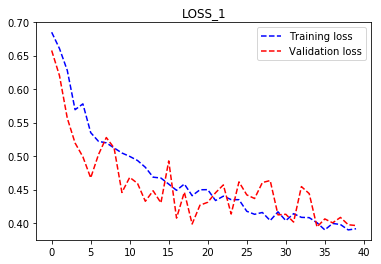

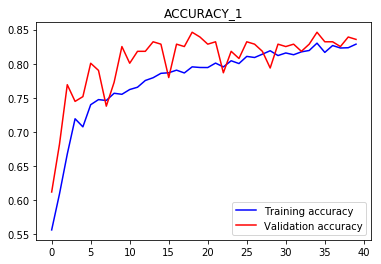

352/352 [==============================] - 0s 650us/step
test_acc 0.8551136363636364
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 32)        0         
___________________________________

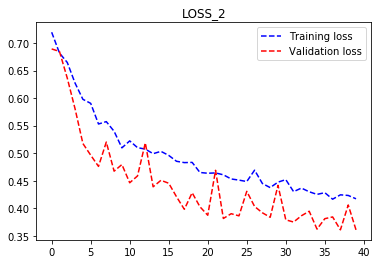

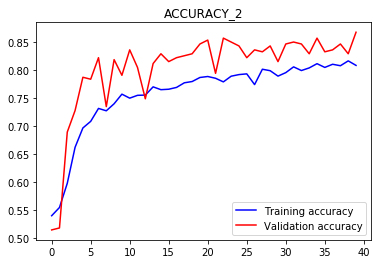

352/352 [==============================] - 0s 389us/step
test_acc 0.8579545454545454
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

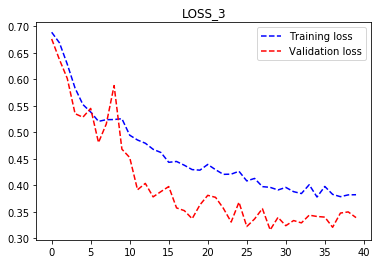

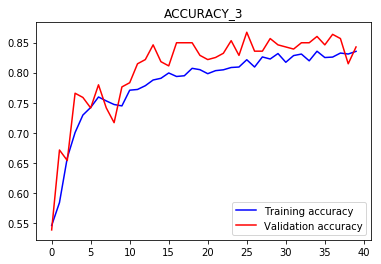

352/352 [==============================] - 0s 413us/step
test_acc 0.8380681818181818
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

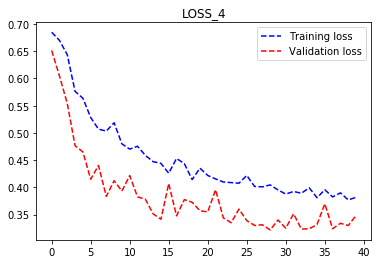

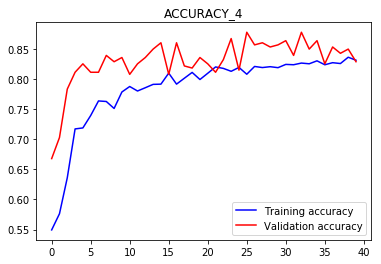

352/352 [==============================] - 0s 419us/step
test_acc 0.8465909090909091
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

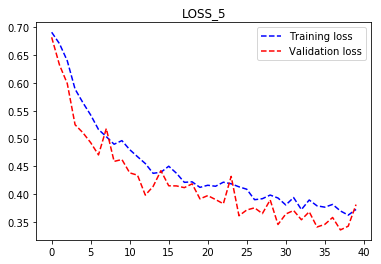

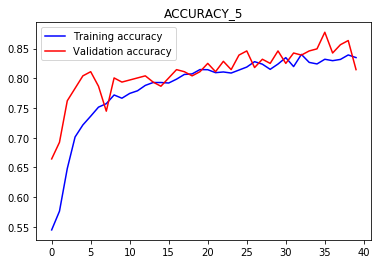

352/352 [==============================] - 0s 436us/step
test_acc 0.8380681818181818
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

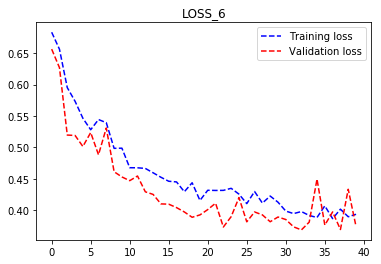

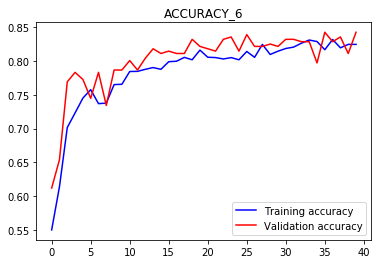

352/352 [==============================] - 0s 429us/step
test_acc 0.8806818181818182
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

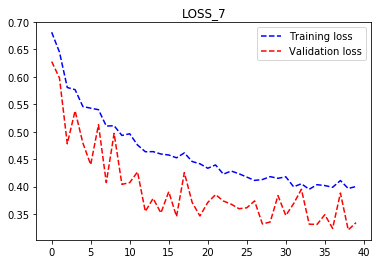

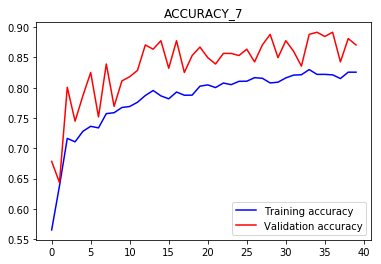

352/352 [==============================] - 0s 426us/step
test_acc 0.8409090909090909
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

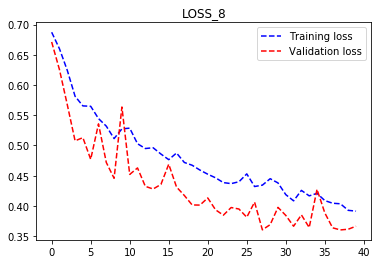

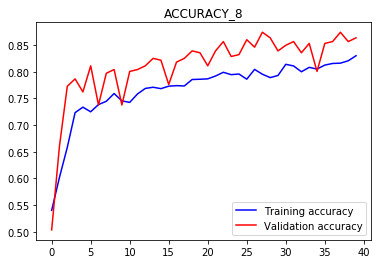

352/352 [==============================] - 0s 428us/step
test_acc 0.8551136363636364
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

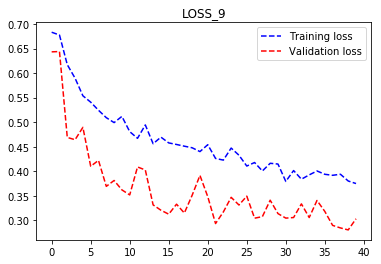

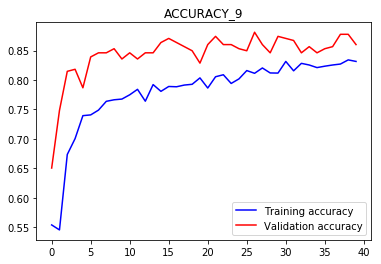

352/352 [==============================] - 0s 427us/step
test_acc 0.8636363636363636
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 18, 18, 32)        0         
__________________________________

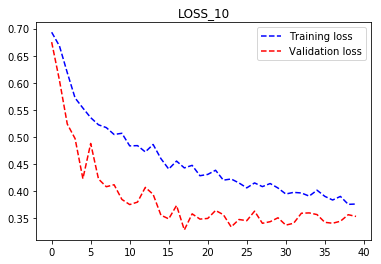

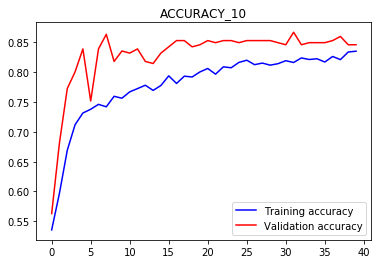

352/352 [==============================] - 0s 445us/step
test_acc 0.8607954545454546
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

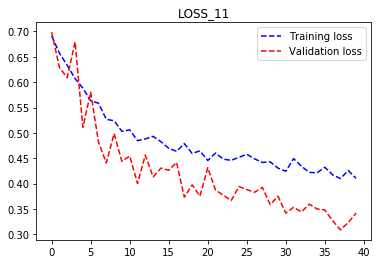

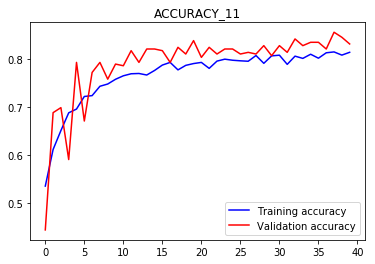

352/352 [==============================] - 0s 446us/step
test_acc 0.8522727272727273
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

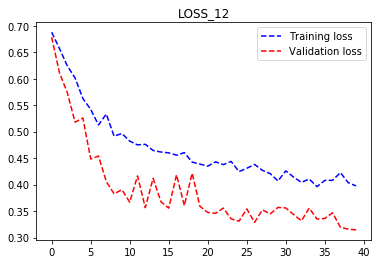

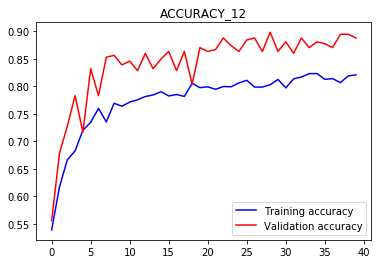

352/352 [==============================] - 0s 414us/step
test_acc 0.8522727272727273
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

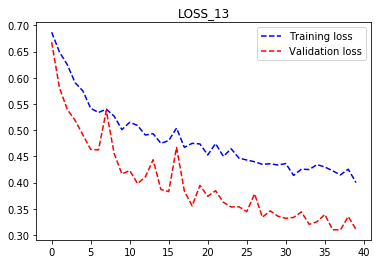

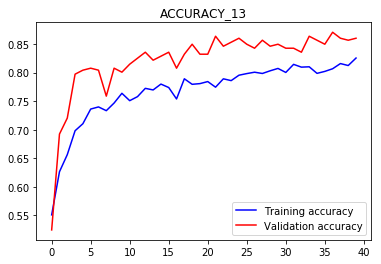

352/352 [==============================] - 0s 413us/step
test_acc 0.84375
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 17, 17, 32)        0         
_____________________________________________

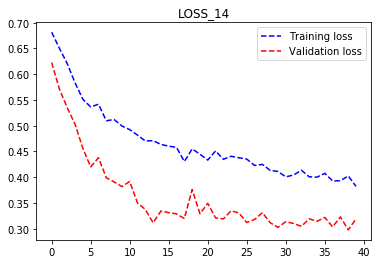

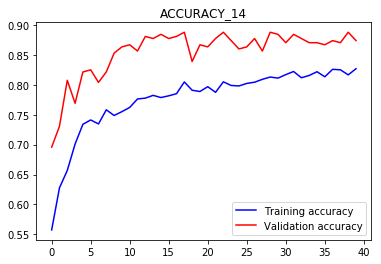

352/352 [==============================] - 0s 419us/step
test_acc 0.8380681818181818
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

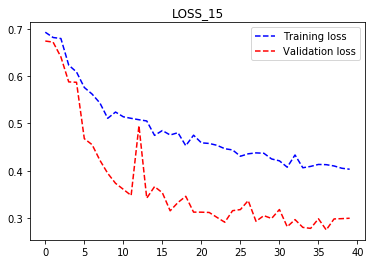

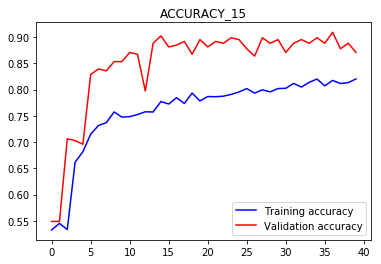

352/352 [==============================] - 0s 412us/step
test_acc 0.8295454545454546
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

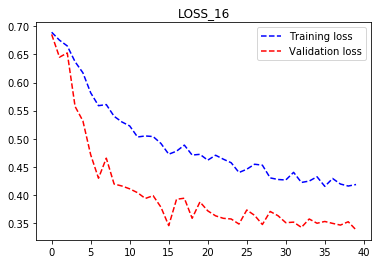

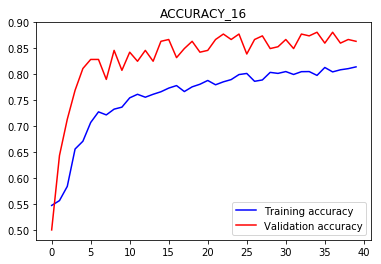

352/352 [==============================] - 0s 495us/step
test_acc 0.8579545454545454
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

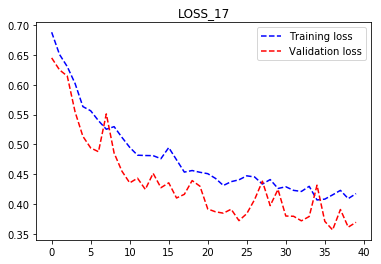

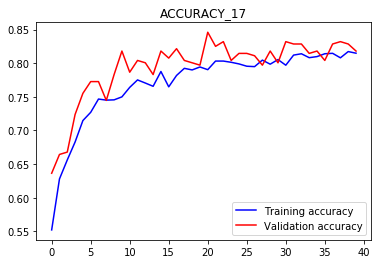

352/352 [==============================] - 0s 426us/step
test_acc 0.8607954545454546
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

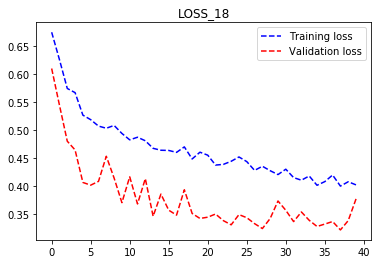

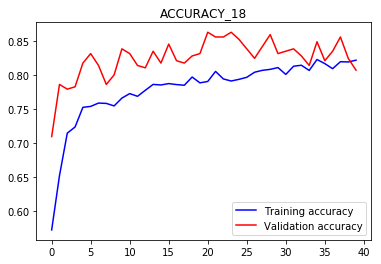

352/352 [==============================] - 0s 440us/step
test_acc 0.8494318181818182
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

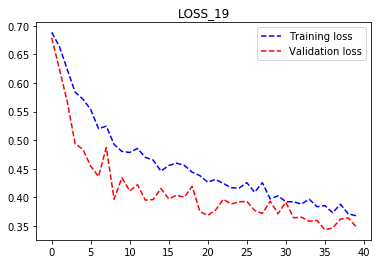

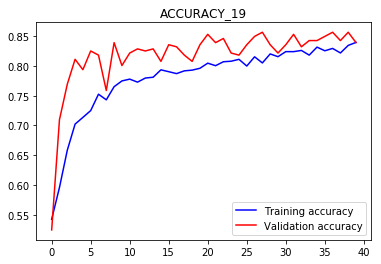

352/352 [==============================] - 0s 431us/step
test_acc 0.8664772727272727
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

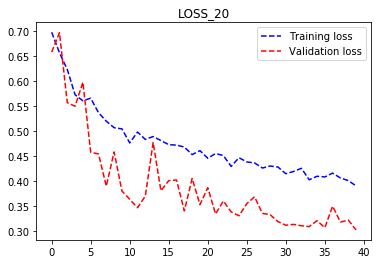

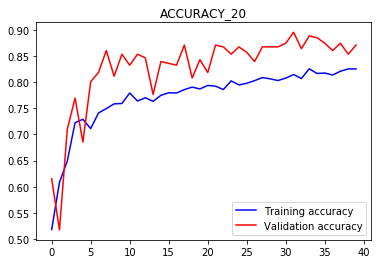

352/352 [==============================] - 0s 424us/step
test_acc 0.8295454545454546
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

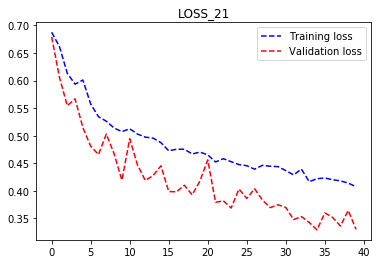

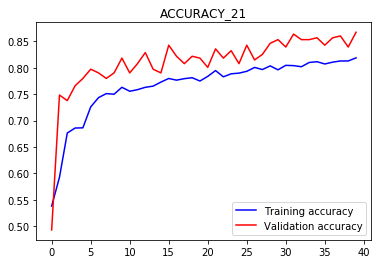

352/352 [==============================] - 0s 539us/step
test_acc 0.8607954545454546
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

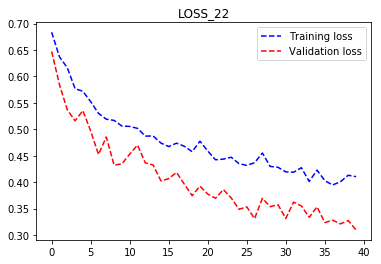

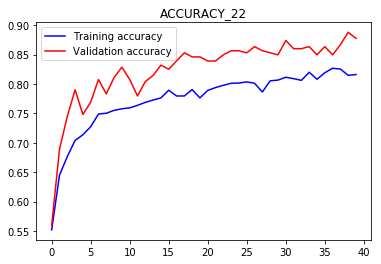

352/352 [==============================] - 0s 474us/step
test_acc 0.8579545454545454
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

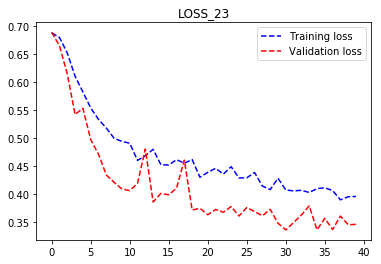

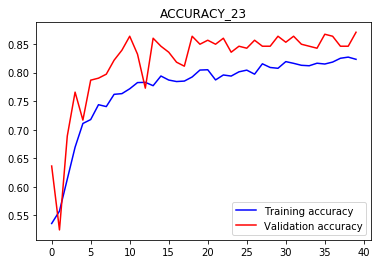

352/352 [==============================] - 0s 496us/step
test_acc 0.8636363636363636
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

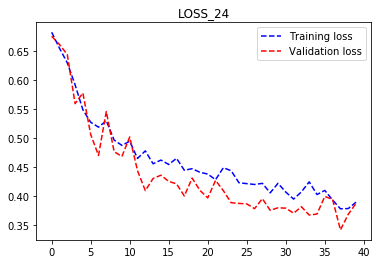

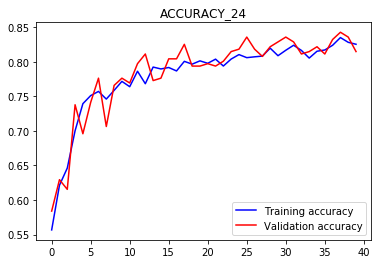

352/352 [==============================] - 0s 420us/step
test_acc 0.8607954545454546
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 17, 17, 32)        0         
__________________________________

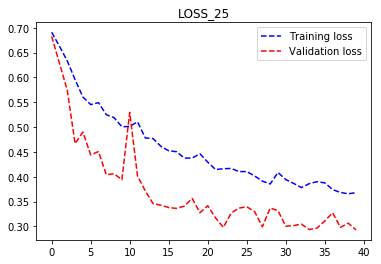

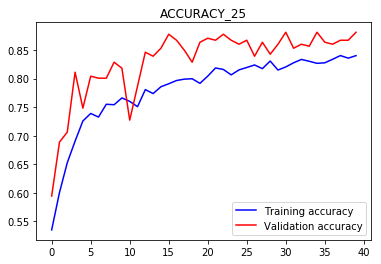

352/352 [==============================] - 0s 377us/step
test_acc 0.8778409090909091


In [0]:
#@title Set folder name in the working directory in which results will be saved(it will be created if non existing), specify to save the .h5 model or not,set the model number and start training 

folder_name = 'TrainedModels_7' #@param{type:"string"}

#@markdown Set *save_last* to True if you want to save the keras models at their last epoch, False otherwise
save_last       = True #@param {type:"boolean"}

#@markdown Set *save_best* to True if you want to save the models at their maximum validation accuracy , False otherwise
save_best       = False #@param {type:"boolean"}

cnn = CNN(train_images_150,train_labels,test_images_150,test_labels)

cnn.data_manipulation()

model_number = 1 #@param {type:"integer"}
models_dict = cnn.create_models_and_plots('generate_models',folder_name,Models_arch,Models_train,save_last , save_best , model_number)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         


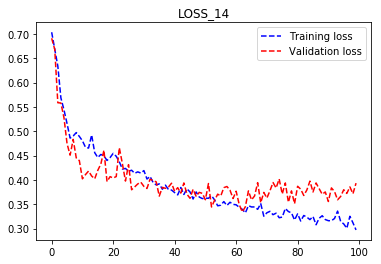

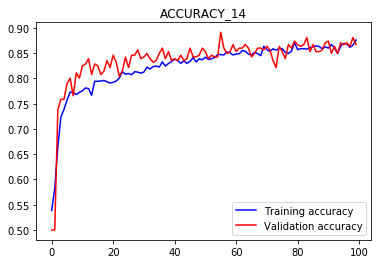

352/352 [==============================] - 0s 579us/step
test_acc 0.8579545454545454
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 32)        0         
___________________________________

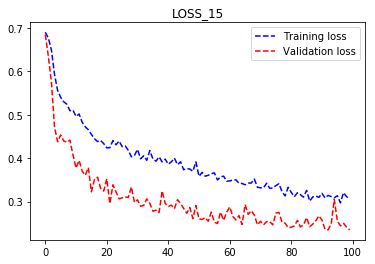

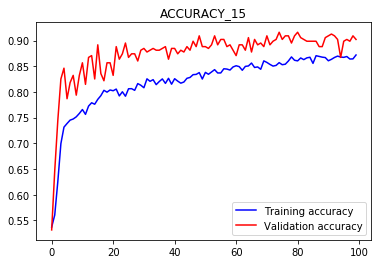

352/352 [==============================] - 0s 621us/step
test_acc 0.8721590909090909
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 32)        0         
___________________________________

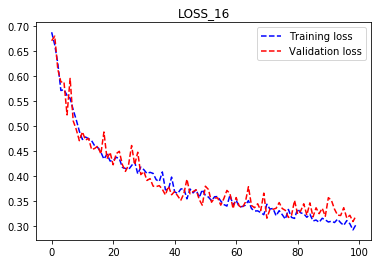

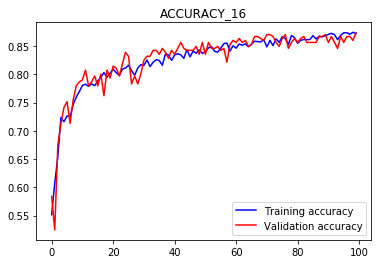

352/352 [==============================] - 0s 540us/step
test_acc 0.9005681818181818
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 32)        0         
___________________________________

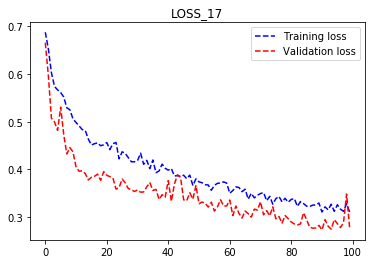

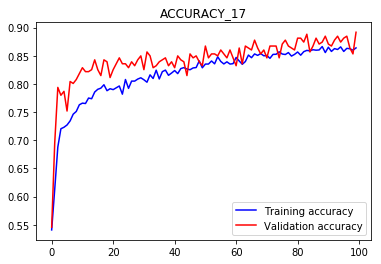

352/352 [==============================] - 0s 432us/step
test_acc 0.8778409090909091
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 18, 18, 32)        0         
___________________________________

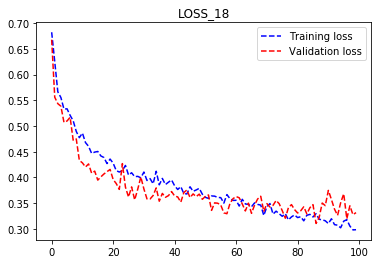

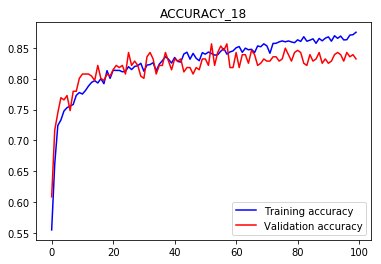

352/352 [==============================] - 0s 429us/step
test_acc 0.8778409090909091
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 32)        0         
___________________________________

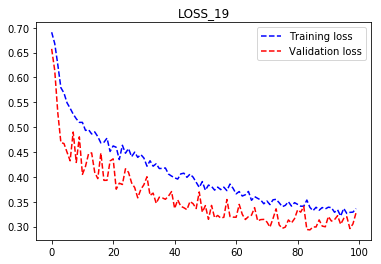

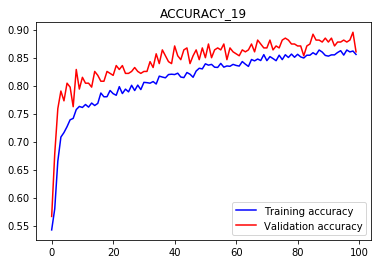

352/352 [==============================] - 0s 523us/step
test_acc 0.8721590909090909
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 32)        0         
___________________________________

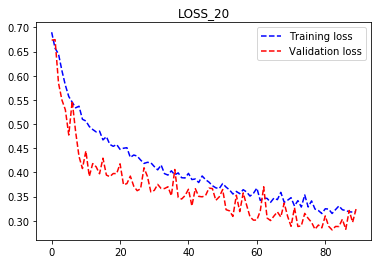

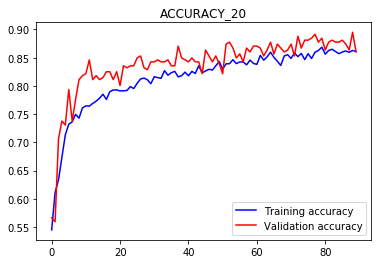

352/352 [==============================] - 0s 392us/step
test_acc 0.875


In [0]:
#@title Retrain the CNN that have given the best accuracies on the test set

#@markdown Set the name of the folders in which models have been stored
already_trained_models_folder_name = 'TrainedModels' #@param {type:"string"}

models_dictionaries = build_dict(data_dir,already_trained_models_folder_name)

#@markdown Set how many of the best models must be reloaded
n_bests = 20 #@param {type : "integer" }

#@markdown Set folder name in the working directory in which results will be saved(it will be created if non existing), specify to save the .h5 model or not,set the model number 

best_models_retrained_folder_name = 'ReTrainedModels_1' #@param{type:"string"}

save_last       = True #@param {type:"boolean"}

save_best       = True #@param {type:"boolean"}

model_number = 16 #@param {type:"integer"}

best_models = best_acc_model(models_dictionaries , n_bests ) 

#@markdown Set variable **set_training_process** to False if you want to retrain each CNN with its own training process, to True if you want to use a different training process(which must be specified through the following 7 variables)
set_training_process = True #@param {type : "boolean"}

#@markdown ---
#@markdown Set the number of complete passes through the training dataset through variable *epochs*
epochs = 100 #@param {type:"integer"}
#@markdown Set number of samples processed before the model is updated at each epoch through variable *batch_size*
batch_size       = 100 #@param {type:"integer"}
#@markdown Set the percentage of training set used for validation through variable *validation_split*
validation_split = 0.1 #@param {type:"number"}
#@markdown Set the optimization algorithm through variable *optimizer*
optimizer      = 'Adamax' #@param ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam']
optimizer = optimizer
#@markdown Set the learning rate through variable *learning_rate*
learning_rate = 'default' #@param ["default"] {allow-input: true}
lr=float(learning_rate)
#@markdown Set variable *data_augmentation* to True to use data augmentation, False otherwise
data_augmentation = True #@param {type:"boolean"}
#@markdown Specify the data augmentation process to define the ImageDataGenerator keras object through the following 6 variables

#@markdown ----

featurewise_center = False #@param {type:"boolean"}
featurewise_std_normalization = False #@param {type:"boolean"}
rotation_range = 20 #@param {type:"slider", min:0, max:50, step:10.0}
width_shift_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.2}
height_shift_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.2}
horizontal_flip = True #@param {type:"boolean"}
DA_specs         = [featurewise_center,featurewise_std_normalization,rotation_range,\
                    width_shift_range,height_shift_range,True]

cnn = CNN(train_images_150,train_labels,test_images_150,test_labels)

cnn.data_manipulation()

best_models_retrained_dicts = {}

for mod in best_models :
  
  CNN_arch , CNN_train = def_model(mod)
  if set_training_process == True :
    CNN_train     = [ epochs, batch_size, validation_split, optimizer, lr , data_augmentation, DA_specs ]

  model_dict = cnn.create_models_and_plots('single_model',best_models_retrained_folder_name,CNN_arch,CNN_train,save_last,save_best,model_number)
  best_models_retrained_dicts['model_dict_'+str(j)] = model_dict

  model_number += 1

##############################################################################


# SECTION 3 : The proposed CNN trained from scratch






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 32)        9248      
____________________________________

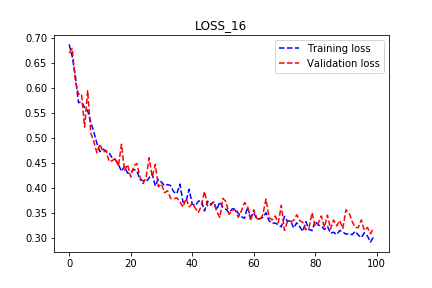

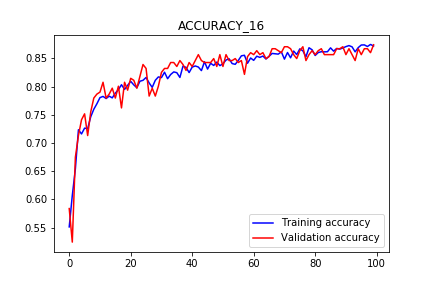

352/352 [==============================] - 4s 10ms/step
test loss is :  0.29906194453889673
test accuracy is :  0.9005681818181818


In [0]:
#@title The best CNN trained from scracth

#@markdown Set the name of the folders in which models have been stored

models_folder_name = 'TrainedModels' #@param {type:"string"}
all_models_dictionaries = build_dict(data_dir,models_folder_name)

best_model_dict = best_acc_model(all_models_dictionaries , 1 )[0]

best_model_folder_path = best_model_dict['path']['model_path']
best_model_number = best_model_dict['path']['model_number']

best_model = load_model(best_model_folder_path+'model_'+ best_model_number +'.h5')

#@markdown Set the name of the folder in which to store the final CNN
final_folder = 'final_scratch' #@param {type : "string" }
dir_name = data_dir + final_folder + '/'
if not os.path.exists(dir_name) :
  os.mkdir(dir_name)
best_model.save(data_dir + final_folder + '/' + 'best_model.h5')  
json.dump(best_model_dict, open(dir_name + 'Model_dict', 'w+'))
best_model.summary()
print('Training process details :')
print(best_model_dict['mod_training'])

from google.colab.patches import cv2_imshow
import cv2

training_loss_history = cv2.imread(best_model_folder_path+'loss_'+ best_model_number +'.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(training_loss_history)

training_acc_history = cv2.imread(best_model_folder_path+'acc_'+ best_model_number +'.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(training_acc_history)

cnn = CNN(train_images_150,train_labels,test_images_150,test_labels)

cnn.data_manipulation()

test_loss, test_acc = best_model.evaluate(cnn.test_data,cnn.test_labels)

print('test loss is : ' , test_loss)
print('test accuracy is : ' , test_acc)
